In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [12]:
file_path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_tds_nodal_2006.nc')
N0_frc = xr.open_dataset(file_path)
file_path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_tds_nodal_2011.nc')
N90_frc = xr.open_dataset(file_path)
file_path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_tds_nodal_2015.nc')
N180_frc = xr.open_dataset(file_path)

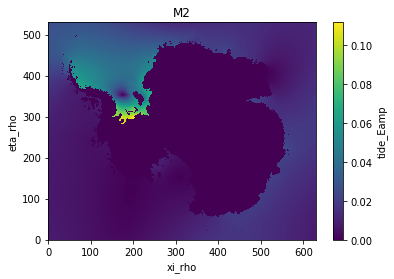

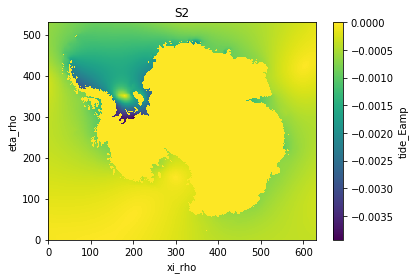

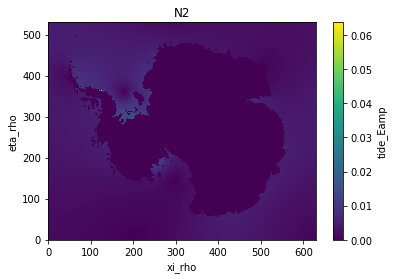

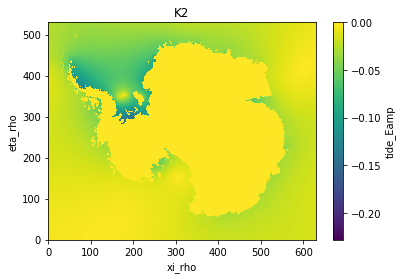

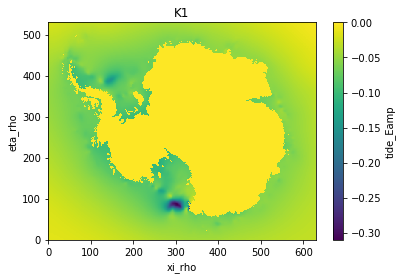

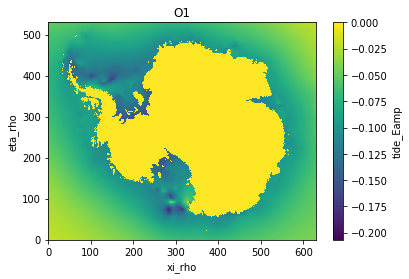

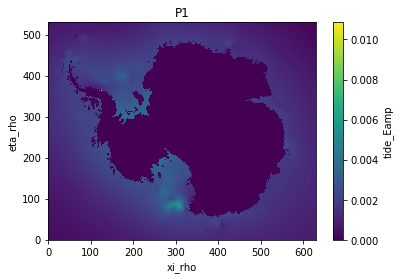

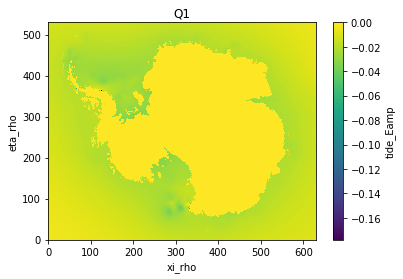

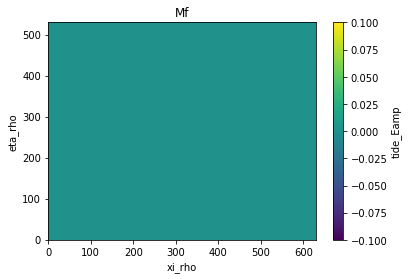

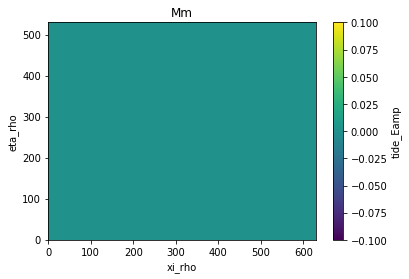

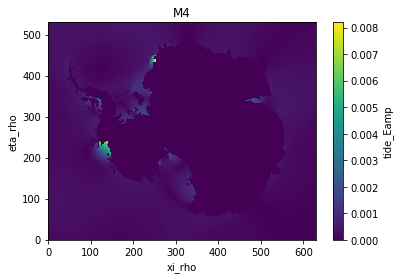

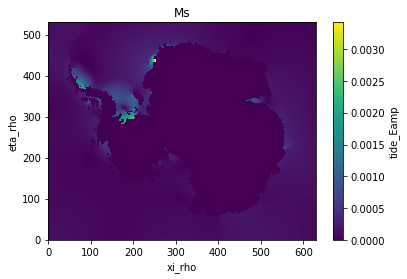

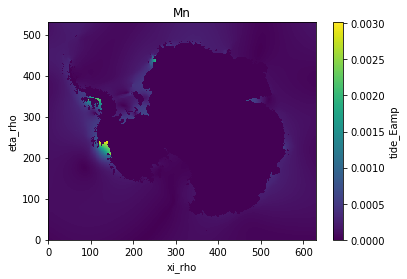

In [15]:
plt.close()
for ind,const in enumerate(['M2','S2','N2','K2','K1','O1','P1','Q1','Mf','Mm','M4','Ms','Mn']):
    ((N180_frc.tide_Eamp[ind] - N0_frc.tide_Eamp[ind])).plot()
    plt.title(const)
    plt.show()

In [1]:
# analysis

In [59]:
#load data
file_path = os.path.join(os.environ.get('rawdir'),'waom10_nodal_2006','ocean_avg_0006.nc')
N0 = xr.open_dataset(file_path)

file_path = os.path.join(os.environ.get('rawdir'),'waom10_nodal_2011','ocean_avg_0006.nc')
N90 = xr.open_dataset(file_path)

file_path = os.path.join(os.environ.get('rawdir'),'waom10_nodal_2015','ocean_avg_0006.nc')
N180 = xr.open_dataset(file_path)

grid_path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_grd.nc')
grd = xr.open_dataset(grid_path)

In [21]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"eta_max,xi_max = find_etaxi(lat_max,lon_max,grd)
%autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)

from features.massloss import plot_ismr_map,calc_circum 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


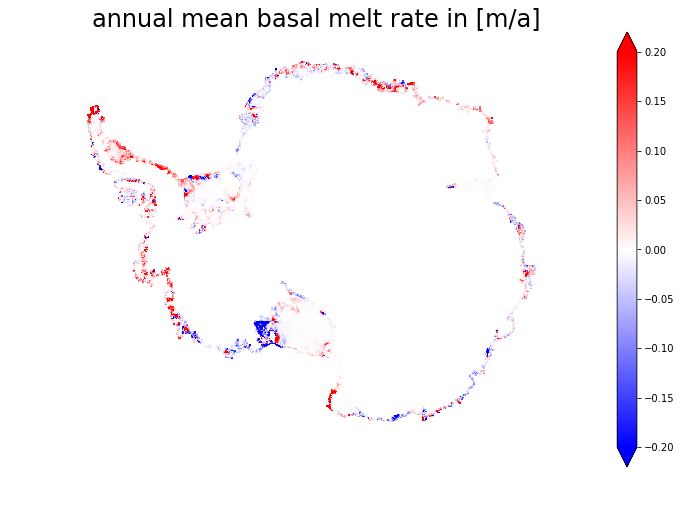

Area of all ice shelves in 10^3 km^2:  1908.84168511
Area average melt rate in m/yr:  0.011566597814766023
Basal mass loss in Gt/a:  22.63077416534779


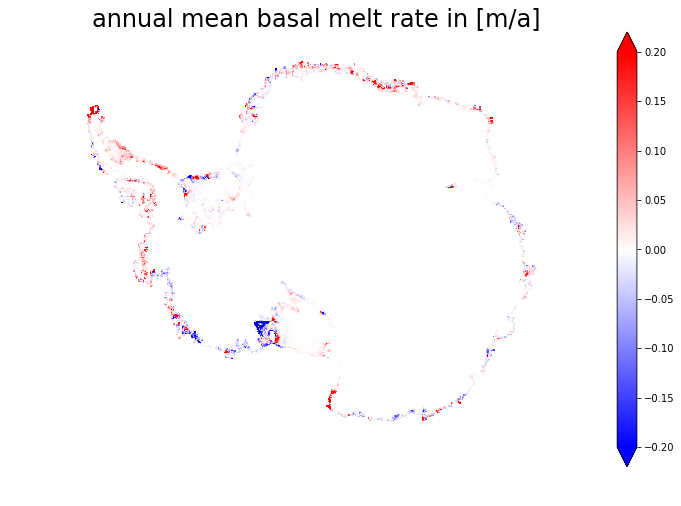

Area of all ice shelves in 10^3 km^2:  1908.84168511
Area average melt rate in m/yr:  0.005715299157941317
Basal mass loss in Gt/a:  11.182341307454617


In [60]:
ism = (grd.zice < 0.0)&(grd.mask_rho==1)
ism.values[200:300,400:500] = False

plot_ismr_map(N0.m - N180.m,ism,-0.2,0.2,grd=grd)
calc_circum(N0.m - N180.m,ism,grd)

plot_ismr_map(N90.m - N180.m,ism,-0.2,0.2,grd=grd)
calc_circum(N90.m - N180.m,ism,grd)

In [73]:
s2a = 24*3600*365
NM = xr.Dataset({"N180N0":(N0.m-N180.m).where(ism).mean("ocean_time")*s2a,"N90N0":(N0.m-N90.m).where(ism).mean("ocean_time")*s2a,
                 "N180N90":(N90.m-N180.m).where(ism).mean("ocean_time")*s2a,"lat":grd.lat_rho,"lon":grd.lon_rho})

In [74]:
NM['N180N0'].attrs={'longitude moons ascending node from':180,'longitude moons ascending node to':0,
                  'year from:':2015,'year to:':2025}
NM['N90N0'].attrs={'longitude moons ascending node from':90,'longitude moons ascending node to':0,
                  'year from:':2020,'year to:':2025}
NM['N180N90'].attrs={'longitude moons ascending node from':180,'longitude moons ascending node to':90,
                  'year from:':2015,'year to:':2020}
for xa in ["N180N0","N90N0","N180N90"]:
    NM[xa].attrs['name'] = 'basal melt difference'
    NM[xa].attrs['unit'] = 'm/yr'

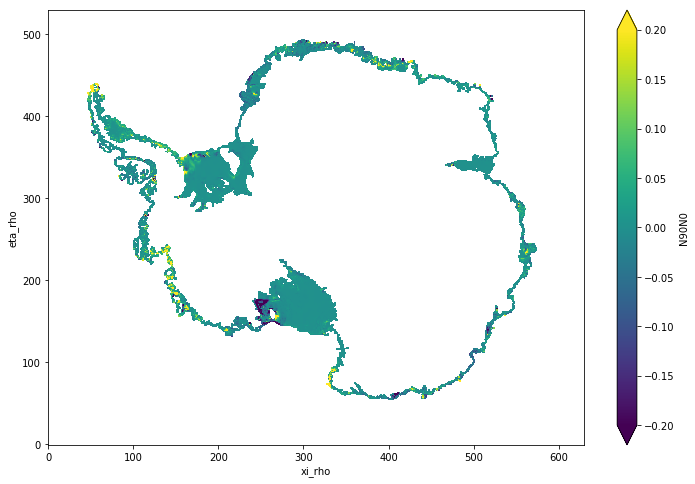

In [76]:
plt.close()
NM.N90N0.plot(size=8,vmax=0.2,vmin=-0.2)
plt.show()

In [77]:
out_path = os.path.join(os.environ.get('projdir'),'data','analysis','processed','waom10_nodal_melt_diff.nc')
NM.to_netcdf(out_path)